# 複素ISTAにFFTを利用する


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/wadayama/MIKA2019/blob/master/fftista.ipynb)

* 通信路は複素AWGN通信路
* 送信信号は8PSK
* 送信側ではIFFTをかける
* 信号長は$n$

## ライブラリのインポート

In [1]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import numpy as np

## デバイスの指定

* GPUを利用する場合には'cuda'と指定する
* CPUを利用する場合には'cpu'と指定する

In [2]:
device = torch.device('cpu') # 'cpu' or 'cuda'

## 複素ライブラリ

* PyTorchで複素数テンソル計算の実行を可能とする

In [3]:
#==================================================================
# Elementary functions
#==================================================================

# tensor addition
def c_add(X, Y):
    return (X[0] + Y[0], X[1] + Y[1])

# tensor subtraction (X - Y)
def c_sub(X, Y):
    return (X[0] - Y[0], X[1] - Y[1])

# Hermitian transpose
def c_ht(X):
    return (X[0].t(), -X[1].t())

# tensor multiplication
def c_mm(X, Y):
    Z_re = torch.mm(X[0], Y[0]) - torch.mm(X[1], Y[1])
    Z_im = torch.mm(X[0], Y[1]) + torch.mm(X[1], Y[0])
    return (Z_re, Z_im) 

# scalar multiplication
def c_scalar_mul(a, X):
    return (a * X[0], a * X[1])

# matrix inverse
def c_inverse(X):
    X_re = X[0]
    X_im = X[1]
    X_re_inv = torch.inverse(X_re)
    tmp = torch.mm(X_im, X_re_inv)
    tmp = torch.mm(tmp, X_im)
    Z_re = torch.inverse(X_re + tmp)
    tmp = - torch.mm(X_re_inv, X_im)
    Z_im = torch.mm(tmp, Z_re)
    return (Z_re, Z_im)

# random matrix with normal distribution
def c_normal(m,n,stdv):
    Z_re = torch.normal(torch.zeros(m,n), std = stdv/math.sqrt(2.0)).to(device)
    Z_im = torch.normal(torch.zeros(m,n), std = stdv/math.sqrt(2.0)).to(device)
    return (Z_re, Z_im)

# pseudo inverse (Moore-Penrose)
def c_pseudo_inverse(X):
    m = X[0].size()[0]
    n = X[0].size()[1]
    X_ht = c_ht(X)
    tmp = c_inverse(c_mm(X_ht, X))
    tmp2 = c_inverse(c_mm(X, X_ht))
    if n < m:
        return c_mm(tmp, X_ht)
    else:
        return c_mm(X_ht, tmp2)
    
# Squared error 
def c_squared_error(X, Y):
    Z_re = X[0] - Y[0]
    Z_im = X[1] - Y[1]
    return ((Z_re**2).sum() + (Z_im**2).sum()).item()

# normalize the norm
def c_normalize(X):
    return (X[0]/torch.sqrt(X[0]**2 + X[1]**2), X[1]/torch.sqrt(X[0]**2 + X[1]**2))

# zero tensor
def c_zeros(m,n):
    return (torch.zeros(m,n).to(device), torch.zeros(m,n).to(device))

# L2-norm
def c_norm(X):
    return torch.sqrt(X[0]**2 + X[1]**2)

# hadamard product
def c_hadamard_prod(X, Y):
    return (X[0]*Y[0]-X[1]*Y[1],X[1]*Y[0]+X[0]*Y[1])

# trace
def c_trace(X):
    return (torch.trace(X[0]),torch.trace(X[1]))

# transpose
def c_t(X):
    return (X[0].t(),X[1].t())

# conjugate
def c_conj(X):
    return (X[0],-X[1])

#==================================================================
# for DFT matrices
#==================================================================

# DFT matrix
def dft(n):
    B_re = torch.zeros(n, n)
    B_im = torch.zeros(n, n)
    for i in range(n):
        for j in range(n):
            B_re[i][j] = math.cos(-2.0*math.pi*i*j/n)/math.sqrt(n)
            B_im[i][j] = math.sin(-2.0*math.pi*i*j/n)/math.sqrt(n)
    return (B_re.to(device), B_im.to(device))

# IDFT matrix
def idft(n):
    B_re = torch.zeros(n, n)
    B_im = torch.zeros(n, n)
    for i in range(n):
        for j in range(n):
            B_re[i][j] = math.cos(2.0*math.pi*i*j/n)/math.sqrt(n)
            B_im[i][j] = math.sin(2.0*math.pi*i*j/n)/math.sqrt(n)
    return (B_re.to(device), B_im.to(device))

#==================================================================
# for FFT functions 
#==================================================================

# FFT
def c_fft(x): # input is assumed to be a tensor of size mbs x n
    a = x[0]
    b = x[1]
    bs = a.size()[0]
    nu = a.size()[1]
    a2 = a.view(bs, 1, nu)
    a3 = torch.transpose(a2, 1, 2)
    b2 = b.view(bs, 1, nu)
    b3 = torch.transpose(b2, 1, 2).view(bs, nu, 1)
    x_in = torch.cat([a3,b3], dim=2)
    p = torch.fft(x_in, 1, normalized=True)
    out_re = p[:,:,0].view(bs, nu)
    out_im = p[:,:,1].view(bs, nu)
    return (out_re, out_im)

# Inverse FFT
def c_ifft(x): # input is assumed to be a tensor of size mbs x n
    a = x[0]
    b = x[1]
    bs = a.size()[0]
    nu = a.size()[1]
    a2 = a.view(bs, 1, nu)
    a3 = torch.transpose(a2, 1, 2)
    b2 = b.view(bs, 1, nu)
    b3 = torch.transpose(b2, 1, 2).view(bs, nu, 1)
    x_in = torch.cat([a3,b3], dim=2)
    p = torch.ifft(x_in, 1, normalized=True)
    out_re = p[:,:,0].view(bs, nu)
    out_im = p[:,:,1].view(bs, nu)
    return (out_re, out_im)

## グローバル定数の設定

In [4]:
n = 128 # 信号長
max_itr = 10 # ISTAの反復回数
mbs   = 20 # ミニバッチサイズ

## 信号点配置の定義 (この例では8PSKを仮定)

In [5]:
# QPSK
#M = 4
#point = torch.tensor([
#    [0.70107, 0.70107],
#    [0.70107, -0.70107],
#    [-0.70107, 0.70107],
#    [-0.70107, -0.70107],
#])

# 8PSK
M = 8 # 信号点数
point = torch.tensor([
    [1.0, 0.0],
    [0.0, 1.0],
    [-1.0, 0.0],
    [0.0,-1.0],
    [0.70107, 0.70107],
    [0.70107, -0.70107],
    [-0.70107, 0.70107],
    [-0.70107, -0.70107],
])

## ミニバッチ生成関数

In [6]:
def gen_minibatch():
    re = []
    im = []
    for i in range(mbs):
        rindex = torch.randint(M, (1,n)).view(n)
        tmp = torch.index_select(point, 0, rindex)
        re.append(tmp[:,0].to(device))
        im.append(tmp[:,1].to(device))
    return (torch.stack(re), torch.stack(im)) 

## 学習可能な複素ISTA クラス

In [7]:
class C_ISTA(nn.Module):
    def __init__(self, max_itr):
        super(C_ISTA, self).__init__()
        self.beta = nn.Parameter(0.1*torch.ones(max_itr)) # 学習可能ステップサイズ
        self.lam = nn.Parameter(0.1*torch.ones(max_itr)) # 収縮関数制御パラメータ
    def c_shrinkage(self, x, var_mat):
        eps = 1e-10
        num_re = torch.zeros(mbs, n).to(device)
        num_im = torch.zeros(mbs, n).to(device)
        deno   = torch.zeros(mbs, n).to(device) + eps
        for i in range(M):
            r = (x[0] - point[i][0])**2 + (x[1] - point[i][1])**2
            f = torch.exp(-r/var_mat)
            num_re += point[i][0] * f
            num_im += point[i][1] * f
            deno += f
        return (num_re/deno, num_im/deno)
    def forward(self, y, num_itr):
        s = c_zeros(mbs, n) # 初期探索点
        for i in range(num_itr):
            tmp = c_sub(y, c_ifft(s))
            tmp2 = c_scalar_mul(self.beta[i], c_fft(tmp))
            r = c_add(s, tmp2)
            s = self.c_shrinkage(r, self.lam[i])
        return s

## インスタンス作成

In [8]:
model = C_ISTA(max_itr).to(device)
opt   = optim.Adam(model.parameters(), lr=0.001) 
loss_func = nn.MSELoss()

## 平均エネルギーの測定

In [9]:
Es = 0.0
for i in range(100):
    x = gen_minibatch()
    t = c_ifft(x)
    Es += ((c_norm(t)**2).sum()/(mbs*n)).detach().cpu().item()
Es = Es / 100
print(Es)

0.9914933198690414


## SN比の設定

In [10]:
snr = 15.0
sigma = math.sqrt(Es * 10.0**(-snr/10.0))
print('sigma = ', sigma)

sigma =  0.17706996288552304


## 訓練ループ

In [11]:
for gen in tqdm(range(max_itr)):
    for i in range(200):
        x = gen_minibatch()
        w = c_normal(mbs, n, sigma)
        t = c_ifft(x)
        y = c_add(t, w)
        opt.zero_grad()
        x_hat = model(y, gen + 1)
        loss  = loss_func(x_hat[0], x[0]) + loss_func(x_hat[1], x[1])
        loss.backward()
        opt.step()

100%|██████████| 10/10 [00:39<00:00,  5.56s/it]


## 学習可能ISTAの試験再現のための準備

In [12]:
def gen_word():
    rindex = torch.randint(M, (1,n)).view(n)
    tmp = torch.index_select(point, 0, rindex)
    return rindex, (tmp[:,0].view(1,n).to(device), tmp[:,1].view(1,n).to(device)) 
mbs = 1
rind, x = gen_word()
w = c_normal(mbs, n, sigma)
t = c_ifft(x)
y = c_add(t, w)
with torch.no_grad():
    s = model(y, max_itr)
x_re = x[0][0].cpu().numpy()
x_im = x[1][0].cpu().numpy()
s_re = s[0][0].cpu().detach().numpy()
s_im = s[1][0].cpu().detach().numpy()

## 送信信号と再現信号の実部の表示

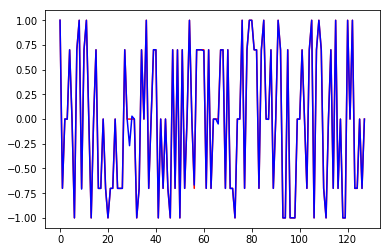

In [13]:
plt.plot(range(n), x_re, color="red")
plt.plot(range(n), s_re, color="blue")

## 送信信号と再現信号の虚部の表示

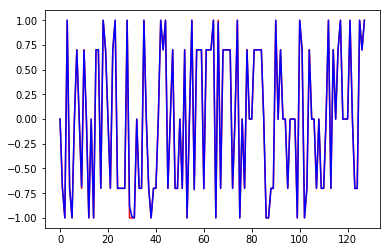

In [14]:
plt.plot(range(n), x_im, color="red")
plt.plot(range(n), s_im, color="blue")

## ZF推定(FFTの実行による)推定結果の表示 (実部)

In [15]:
s = c_fft(y)
t_re = s[0][0].cpu().detach().numpy()
t_im = s[1][0].cpu().detach().numpy()

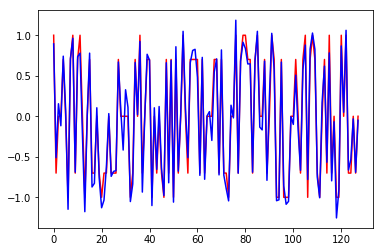

In [16]:
plt.plot(range(n), x_re, color="red")
plt.plot(range(n), t_re, color="blue")

## ZF推定(FFTの実行による)推定結果の表示 (虚部)

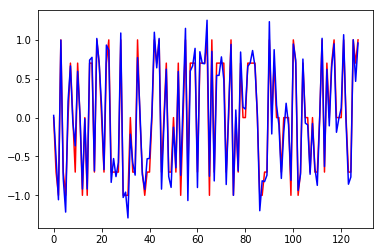

In [17]:
plt.plot(range(n), x_im, color="red")
plt.plot(range(n), t_im, color="blue")

## 送信信号の散布図

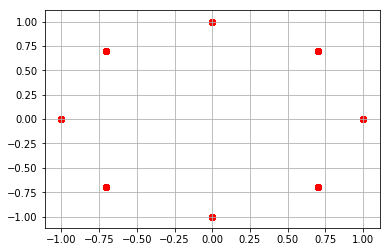

In [18]:
plt.grid()
plt.scatter(x_re, x_im, color="red")

## 学習可能ISTAによる推定信号の散布図

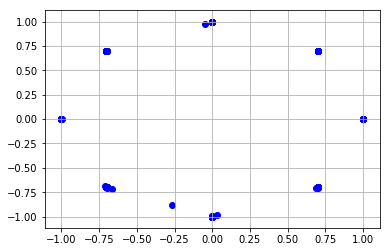

In [19]:
plt.grid()
plt.scatter(s_re, s_im, color="blue")

## FFT(ZF)推定による推定信号の散布図

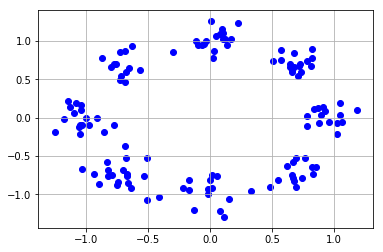

In [20]:
plt.grid()
plt.scatter(t_re, t_im, color="blue")